In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [5]:
# Step 1: Load Datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [6]:
# Aggregate transaction data for customer-level features
transaction_features = transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_spend=('TotalValue', 'mean'),
    total_quantity=('Quantity', 'sum'),
    unique_products=('ProductID', 'nunique')
).reset_index()

# Merge customer profile information with transaction features
customer_data = pd.merge(customers, transaction_features, on='CustomerID', how='inner')

# Check if 'Category' column exists in customer_data, otherwise skip encoding
if 'Category' in customer_data.columns:
    customer_data['Category'] = label_encoder.fit_transform(customer_data['Category'])
else:
    print("Warning: 'Category' column not found in customer_data. Skipping encoding.")

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['total_spend', 'avg_spend', 'total_quantity', 'unique_products']
scaled_features = scaler.fit_transform(customer_data[numerical_features])

# When selecting features for scaling, exclude 'Category' if it's not present:
features_for_scaling = ['Region']
if 'Category' in customer_data.columns:
    features_for_scaling.append('Category')

customer_data_scaled = np.hstack((scaled_features, customer_data[features_for_scaling].values))

In [7]:
from sklearn.preprocessing import OneHotEncoder
encoded_features = pd.get_dummies(customer_data[['Region']]) # Include 'Category' if it's in your data
customer_data_scaled = np.hstack((scaled_features, encoded_features.values))

In [8]:
# Step 3: Apply Clustering Algorithm
# Determine optimal number of clusters using Davies-Bouldin Index
db_scores = []
clusters_range = range(2, 11)
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(customer_data_scaled)
    db_index = davies_bouldin_score(customer_data_scaled, cluster_labels)
    db_scores.append(db_index)

In [9]:
# Select optimal number of clusters (minimizing DB Index)
optimal_k = clusters_range[np.argmin(db_scores)]

In [10]:
# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

In [11]:
# Step 4: Calculate Metrics
silhouette_avg = silhouette_score(customer_data_scaled, customer_data['Cluster'])
db_index = davies_bouldin_score(customer_data_scaled, customer_data['Cluster'])

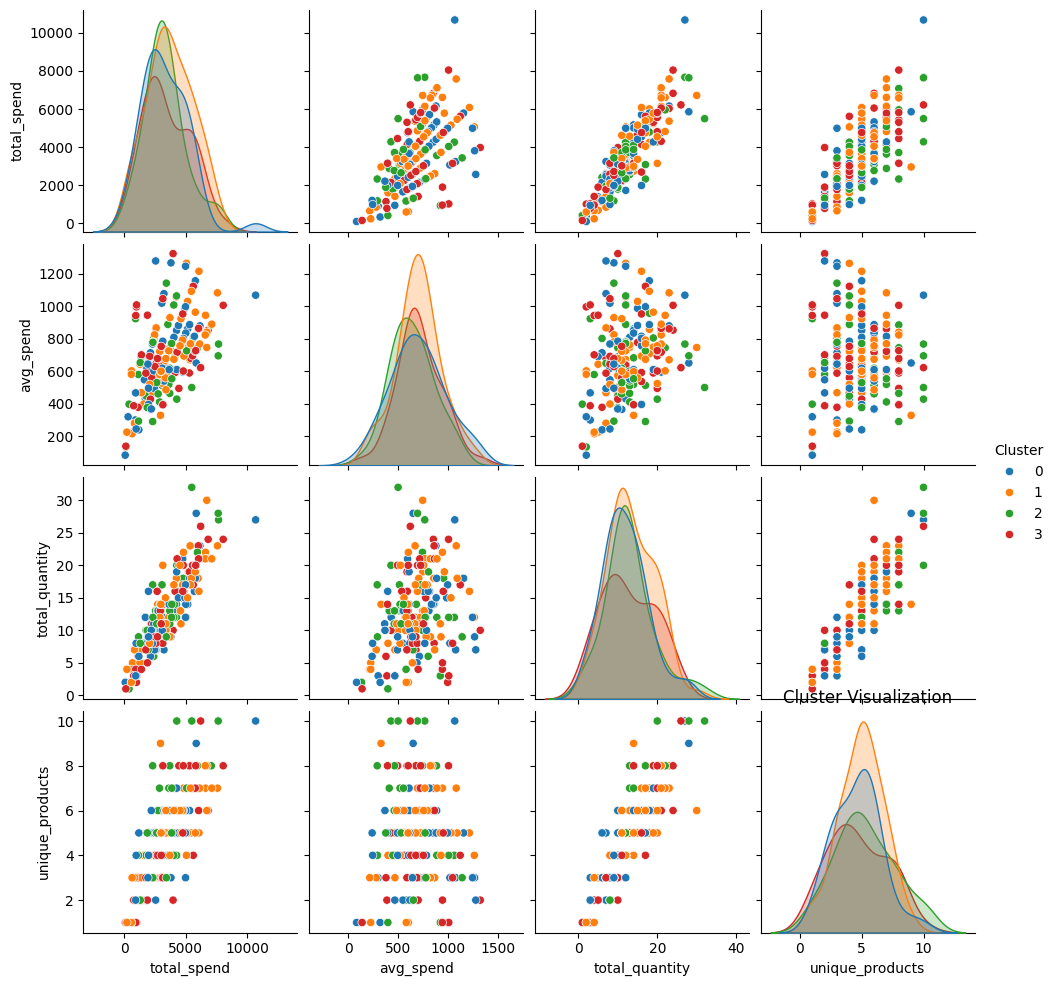

In [12]:
# Step 5: Visualize Clusters
# Pairplot for cluster visualization
sns.pairplot(customer_data, hue='Cluster', vars=numerical_features, palette='tab10')
plt.title('Cluster Visualization')
plt.show()

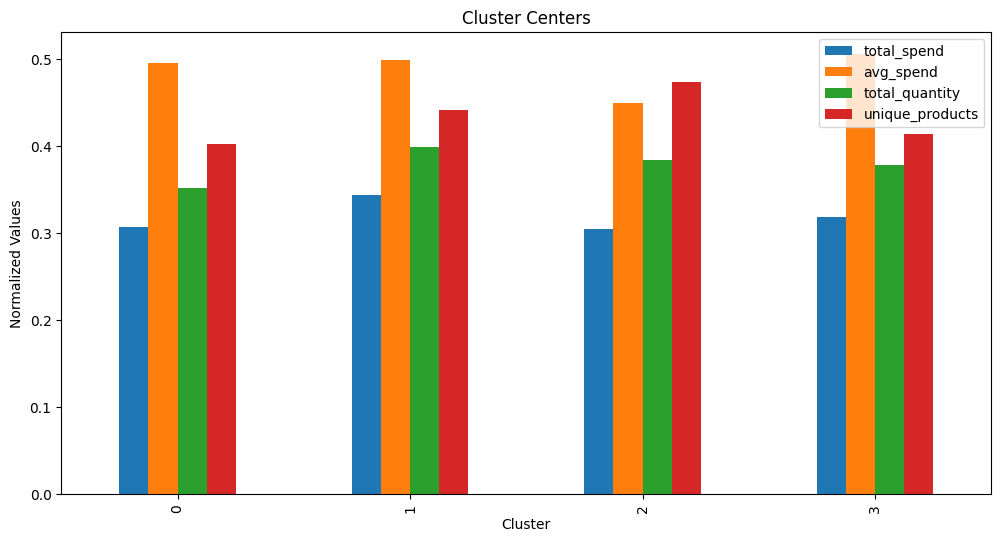

In [13]:
# Cluster centers visualization
# Get all feature names (including one-hot encoded features)
all_feature_names = numerical_features + list(encoded_features.columns)

# Create DataFrame with correct column names
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=all_feature_names)

# Plot only the original numerical features
cluster_centers[numerical_features].plot(kind='bar', figsize=(12, 6))
plt.title('Cluster Centers')
plt.ylabel('Normalized Values')
plt.xlabel('Cluster')
plt.legend(loc='best')
plt.show()

In [14]:
# Print clustering results
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

Optimal number of clusters: 4
Davies-Bouldin Index: 0.5129588993073806
Silhouette Score: 0.6708002370066852
